<a href="https://colab.research.google.com/github/raymondkim777/ViolinAI/blob/main/violinv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
data_dir = pathlib.Path('/content/gdrive/My Drive/datasets/violin')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['high' 'low' 'mid']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 98
Number of examples per label: 36
Example file tensor: tf.Tensor(b'/content/gdrive/My Drive/datasets/violin/low/\xe1\x84\x8e\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb821.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:80]
val_files = filenames[80: 80 + 8]
test_files = filenames[-10:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 80
Validation set size 8
Test set size 10


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

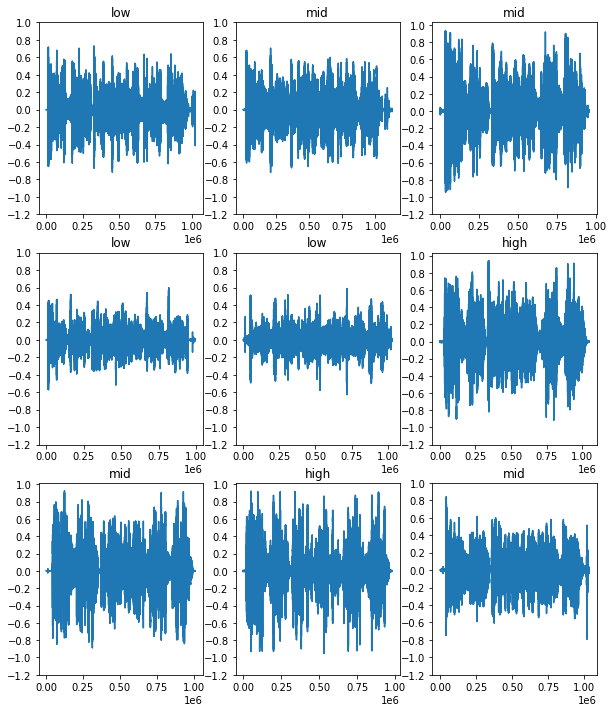

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  waveform = tf.cast(waveform, tf.float32)
  equal_length = waveform[100000:700000]
  spectrogram = tf.signal.stft(
      equal_length, frame_length=1025, frame_step=512)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: low
Waveform shape: (1022793,)
Spectrogram shape: (1170, 1025)
Audio playback


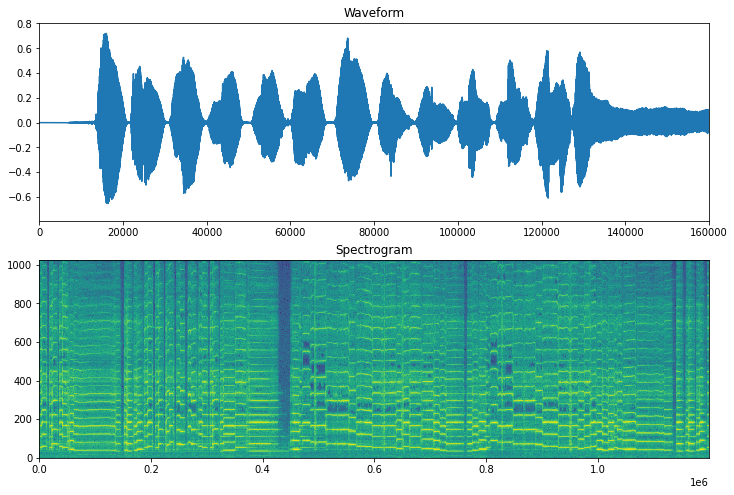

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 160000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

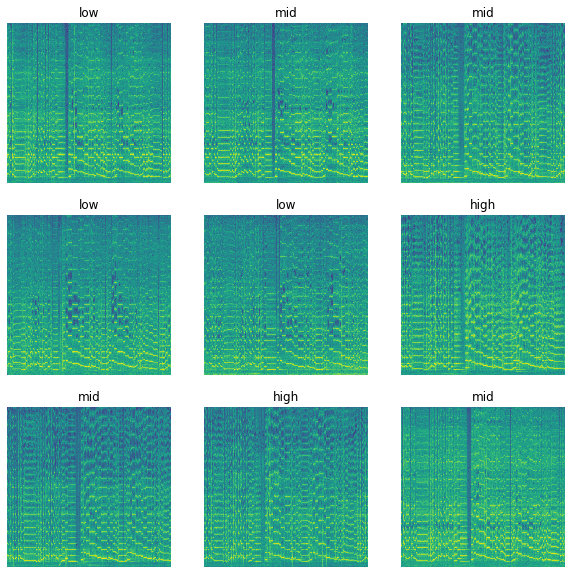

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
print(test_files)

tf.Tensor(
[b'/content/gdrive/My Drive/datasets/violin/high/\xe1\x84\x80\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb816.wav'
 b'/content/gdrive/My Drive/datasets/violin/low/\xe1\x84\x8e\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb817.wav'
 b'/content/gdrive/My Drive/datasets/violin/high/\xe1\x84\x80\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb830.wav'
 b'/content/gdrive/My Drive/datasets/violin/low/\xe1\x84\x8e\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb825.wav'
 b'/content/gdrive/My Drive/datasets/violin/mid/\xe1\x84\x8c\xe1\x85\xae\xe1\x86\xbc\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb82.wav'
 b'/content/gdrive/My Drive/datasets/violin/low/\xe1\x84\x8e\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb819.wav'
 b'/content/gdrive/My Drive/datasets/violin/mid/\xe1\x84\x8c\xe1\x85\xae\xe1\x86\xbc\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb89.wav'
 b'/content/gdrive/My Drive/datasets/violin/high/\xe1\x84\x80\xe1\x85\xa9\xe1\x84\x80\xe1\x85\xb3\xe1\x86\xb818.wav'
 b'/content/gdrive/My Drive/datasets

In [ ]:
batch_size = 4
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(128, 128),
    norm_layer,
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1170, 1025, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 128)     1280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 256)     295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
20/20 [==============================] - 105s 5s/step - loss: 4.0668 - accuracy: 0.4125 - val_loss: 1.0840 - val_accuracy: 0.2500
Epoch 2/10
20/20 [==============================] - 86s 4s/step - loss: 0.9229 - accuracy: 0.6250 - val_loss: 0.7787 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 87s 4s/step - loss: 0.5116 - accuracy: 0.8375 - val_loss: 0.5644 - val_accuracy: 0.8750
Epoch 4/10
20/20 [==============================] - 88s 4s/step - loss: 0.4596 - accuracy: 0.8125 - val_loss: 0.5494 - val_accuracy: 0.7500
Epoch 5/10
20/20 [==============================] - 86s 4s/step - loss: 0.3088 - accuracy: 0.8750 - val_loss: 0.4382 - val_accuracy: 0.8750
Epoch 6/10
20/20 [==============================] - 86s 4s/step - loss: 0.2235 - accuracy: 0.9125 - val_loss: 0.3467 - val_accuracy: 0.8750
Epoch 7/10
20/20 [==============================] - 87s 4s/step - loss: 0.2433 - accuracy: 0.8875 - val_loss: 0.3834 - val_accuracy: 0.8750
Epoch 8/10
20/20 [=

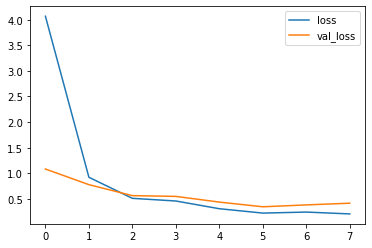

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 70%


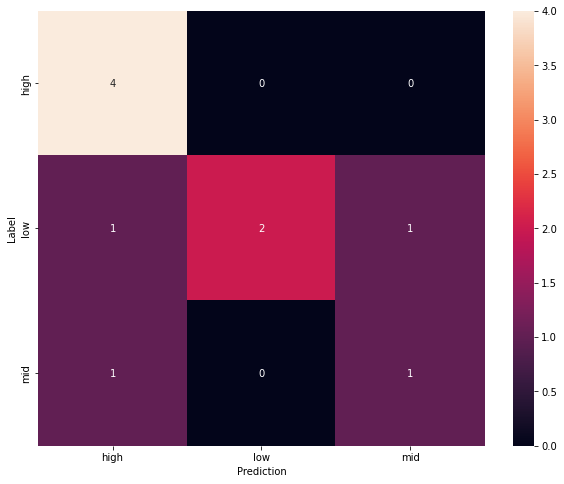

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

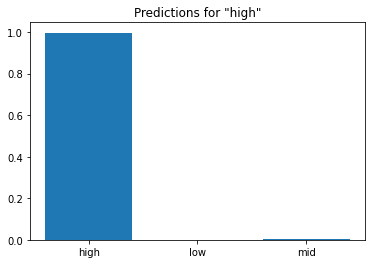

In [ ]:
sample_file = data_dir/'high/고급22.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
# Extract the outputs of the two conv layers
layer_outputs = [layer.output for layer in model.layers[1:4]]
# Create a model returning the layer_outputs for the model input
act_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1170, 1025, 1)]   0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
normalization_1 (Normalizati (None, 128, 128, 1)       3         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 128)     1280      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 256)     295168    
Total params: 296,451
Trainable params: 296,448
Non-trainable params: 3
_________________________________________________________________


In [ ]:
activations = act_model.predict(sample_ds.batch(1))

In [ ]:
[print(act.shape) for act in activations];

(1, 128, 128, 1)
(1, 126, 126, 128)
(1, 124, 124, 256)


In [ ]:
plt.matshow(activations[1][0,:,:,127], cmap='viridis')

In [ ]:
def plot_conv_layer(which_conv):
    # Plot conv layer activation
    # which_conv = 0 # 0=first, 1=second
    img_per_row = 10
    n_feat = activations[which_conv].shape[-1] # number of feature maps
    size = activations[which_conv].shape[1] # image feature (e.g., 26)
    n_col = np.round(n_feat/img_per_row).astype('int')
    display_grid = np.zeros((size*n_col, img_per_row*size))
    # Add each filter into the grids
    for col in range(n_col):
        for row in range(img_per_row):
            if col*img_per_row+row < size:
                img = activations[which_conv][0,:,:,col*img_per_row+row]
                # Post-process images
                img -= img.mean()
                img -= img.std()
                img *= 64
                img += 128
                img = np.clip(img, 0, 255).astype('uint8')
                display_grid[col*size:(col+1)*size,
                             row*size:(row+1)*size] = img
    scale = 1/size
    fig, ax = plt.subplots(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    ax.set_title(f'ConvLayer = {which_conv+1}')
    ax.grid(False)
    ax.imshow(display_grid, aspect='auto', cmap='viridis')
    return fig, ax

In [ ]:
plot_conv_layer(1)

In [ ]:
plot_conv_layer(2)

In [ ]:
which_number = 1
test_input = []
test_labels = []

for audio, label in sample_ds:
  test_input.append(audio.numpy())
  test_labels.append(label.numpy())

# Visualize test_input
plt.imshow(test_input.squeeze());

In [ ]:
tf.compat.v1.disable_eager_execution()
# Get output vector
output_vector = model.output[:, which_number]
# Get the last convolutional layer
last_conv_layer = model.layers[3]
# Get the gradient of the given number with regard to the output feature map of the last conv layer
grads = tf.keras.backend.gradients(output_vector, last_conv_layer.output)[0] # (None,24,24,64)
# Get the mean intensity of the gradient over each feature map (64)
pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2)) # 64
# Compute gradient given an inputw
iterate = tf.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([test_input]) # 64, (24,24,64)
# Multiply each channel in the feature map array
# by 'how important this channel is' with regard to the given number
for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
# Calculate channel-wise mean for the heatmap activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

In [ ]:
heatmap = np.maximum(heatmap, 0) # => max(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
# Add 3 channels for coloring the heatmap
img_size = (500, 500)
# Prepare image
test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)
test_input_resized *= 255
# Make heatmap
heatmap_resized = cv2.resize(heatmap, img_size) # (500, 500)
heatmap_resized = np.uint8(255*heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
# Apply heatmap on the original image
superimposed_img = heatmap_resized*0.5 + test_input_resized
# Save
cv2.imwrite('outputs/test.jpg', superimposed_img);

In [ ]:
img = mpimg.imread('outputs/test.jpg')
plt.imshow(img)